In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.gridspec import GridSpec

import ujson, os

from scipy.stats import scoreatpercentile as scap

from cmdstanpy import set_cmdstan_path, CmdStanModel, from_csv
import arviz as az
import corner

from astropy.table import Table
import astropy.units as u
import astropy.constants as c
from astropy.coordinates import Galactocentric, ICRS, CartesianDifferential
au_km_year_per_sec = (c.au / (1*u.yr).to(u.s)).to(u.km/u.s).value

from plotstyles import useagab, apply_tufte
from robuststats import rse

from diskkinematicmodel import *
from icrstogal import *
from loadmwsamples import *

useagab()

In [6]:
def hist_means(x_data, y_data, bins):
    bin_means = np.zeros(len(bins)-1)
    for i in np.arange(len(bins)-1):
        left_edge = bins[i]
        right_edge = bins[i+1]
        count = 0
        summed = 0
        if right_edge != bins[-1]:
            masked = y_data[(x_data >= left_edge) & (x_data < right_edge)]
        else:
            masked = y_data[(x_data >= left_edge) & (x_data <= right_edge)]
        if len(masked) == 0:
            bin_means[i] = np.nan
        else:
            bin_means[i] = np.mean(masked)
    return bin_means


def hist_plotter(values, bins, labelname = '_ignore', loglog=False):
    x_plot_list = []
    y_plot_list = []
    for i in np.arange(len(bins)-1):
        left_edge = bins[i]
        right_edge = bins[i+1]
        x_plot_list.append(left_edge)
        x_plot_list.append(right_edge)
        # Nog delen door de breedte van de bins? --> Maakt het verschil voor nu alleen maar groter
        # binwidth = right_edge-left_edge
        y_plot_list.append(values[i])  # /binwidth)
        y_plot_list.append(values[i])  # /binwidth)
    if loglog == True:
        plt.loglog(x_plot_list, y_plot_list, label=labelname)
    elif loglog == False:
        plt.plot(x_plot_list, y_plot_list, label=labelname, color = 'red')
    plt.legend()
    return


def minmaxrange(dataset, length = 101):
    return np.linspace(np.min(dataset), np.max(dataset), length)

def mean_plotter(x_data, y_data):
    bins = minmaxrange(x_data)
    means = hist_means(x_data, y_data, bins)
    hist_plotter(means, bins)
    return

## Read in the data

In [2]:
Rsun = 8277.0*u.pc

fgkmtable = load_mwtable('./data/FGKMGoldenSample.fits', Rsun=Rsun, esphs=False)

giants
Number of stars in selected sample: 23789


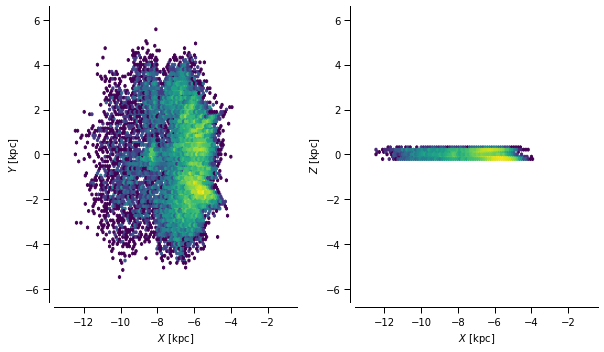

In [3]:
plx_snrlim = 10
vtanhalo = 180.0

plxfilter = fgkmtable['parallax_over_error']>plx_snrlim
zmax = 250
# Added filter:
pmb_sn = np.abs(fgkmtable['pml']/fgkmtable['pml_error'])
pmb_sn_filter = pmb_sn > 0  # 10
#

sample_filter_init = pmb_sn_filter & plxfilter & (np.abs(np.sin(np.deg2rad(fgkmtable['b']))*1000/fgkmtable['parallax']) < zmax)

R_filter = (fgkmtable['R_gc']>6500.0) & (fgkmtable['R_gc']<15000.0)

no_spt_filter = fgkmtable['source_id'] > 0
giants = fgkmtable['logg_gspphot'] <= 3.0
fstars = (fgkmtable['logg_gspphot'] > 4.0 ) & (fgkmtable['teff_gspphot'] > 6000)
gstars = (fgkmtable['logg_gspphot'] > 4.0 ) & (fgkmtable['teff_gspphot'] <= 6000) & (fgkmtable['teff_gspphot'] > 5000)
kstars = (fgkmtable['logg_gspphot'] > 4.0 ) & (fgkmtable['teff_gspphot'] <= 5000) & (fgkmtable['teff_gspphot'] > 4000)
mstars = (fgkmtable['logg_gspphot'] > 4.0 ) & (fgkmtable['teff_gspphot'] <= 4000)

# Choice of stars

filter_dictionary = {
                  'no_spt_filter':no_spt_filter,
                  'giants':giants,
                  'fstars':fstars,
                  'gstars':gstars,
                  'kstars':kstars,
                  'mstars':mstars,
                 }
# Choice of stars
filter_of_choice = "giants"

spt_lum_filter = filter_dictionary[filter_of_choice]
fit_save_location = os.path.join(os.getcwd(), 'fitfiles', filter_of_choice)


print(fit_save_location[-len(filter_of_choice):])

###

sample_filter = sample_filter_init & spt_lum_filter #& R_filter

print(f"Number of stars in selected sample: {fgkmtable['ra'][sample_filter].size}")

subsample_size = 3000
if (fgkmtable['ra'][sample_filter].size <=subsample_size):
    fgkm_subsample = fgkmtable[sample_filter]
else:
    random_subsample = np.random.choice(np.arange(fgkmtable['ra'][sample_filter].size), size=subsample_size, replace=False)
    fgkm_subsample = fgkmtable[sample_filter][random_subsample]
    
plotgrid = [-13, -1, -6, 6]
fig=plt.figure(figsize=(8.5,5), tight_layout=True)

gs = fig.add_gridspec(1, 2, figure=fig)

ax_xy = fig.add_subplot(gs[0,0])
apply_tufte(ax_xy)
ax_xz = fig.add_subplot(gs[0,1])
apply_tufte(ax_xz)

ax_xy.hexbin(fgkmtable['x_gc'][sample_filter]/1000, fgkmtable['y_gc'][sample_filter]/1000, mincnt=1, bins='log', extent=plotgrid)
ax_xy.set_xlabel(r'$X$ [kpc]') 
ax_xy.set_ylabel(r'$Y$ [kpc]') 

ax_xz.hexbin(fgkmtable['x_gc'][sample_filter]/1000, fgkmtable['z_gc'][sample_filter]/1000, mincnt=1, bins='log', extent=plotgrid)
ax_xz.set_xlabel(r'$X$ [kpc]') 
ax_xz.set_ylabel(r'$Z$ [kpc]')

plt.show()

## Reading in the fits

In [ ]:
# Reading in earlier produced fits
filter_dictionary = {
                  'no_spt_filter':no_spt_filter,
                  'giants':giants,
                  'fstars':fstars,
                  'gstars':gstars,
                  'kstars':kstars,
                  'mstars':mstars,
                 }
# Choice of stars
filter_of_choice = "giants"

spt_lum_filter = filter_dictionary[filter_of_choice]
fit_save_location = os.path.join(os.getcwd(), 'fitfiles', filter_of_choice)

fgkm_fit = from_csv(path=fit_save_location)
print(fit_save_location[-len(filter_of_choice):])

## Defining the fitted parameters

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


8277.0 pc
8277.0
v0 = 353.50326659508517 km/s


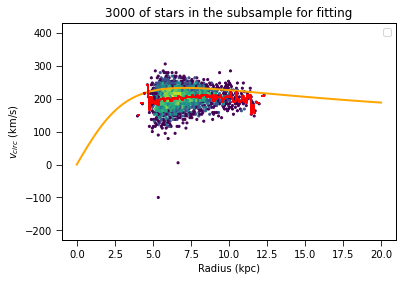

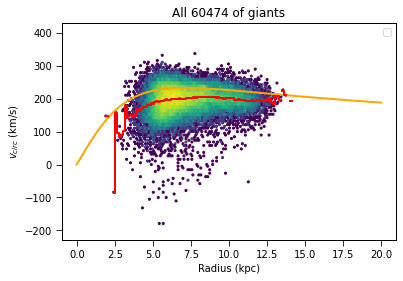

In [51]:
# Importeren van de fitdata wanneer mogelijk

Vcirc_sun = 231.12700
Vcirc_sun_std = 0.147479
hbp = 4.489510
hbp_std = 0.425565
pbp = -0.799196
pbp_std = 0.011664
Vsun_pec_x = 13.523500
Vsun_pec_x_std = 1.006380
Vsun_pec_y = 27.037300
Vsun_pec_y_std = 1.373190
Vsun_pec_z = 8.287450
Vsun_pec_z_std = 0.391901
vdispR = 39.746600
vdispR_std = 0.744815
vdispPhi = 29.551700
vdispPhi_std = 0.801208
vdispZ = 21.277700
vdispZ_std = 0.283643

print(Rsun)
Rsun_value = Rsun.to_value()
print(Rsun_value)
v0 = Vcirc_sun/((Rsun_value/1000)/hbp*(1+((Rsun_value/1000)/hbp)**2)**((pbp-2)/4))
# v0 = vcircsun_samples[i]/rotcur(Rsun.value, h_samples[i], p_samples[i])
print("v0 = {} km/s".format(v0))

def bp_function(r, p_param, h_param, v0):
    rotcur = lambda x : x/h_param * np.power(1 + (x/h_param)**2, (p_param-2)/4)
    vc = v0*rotcur(r)
    return v0 * r/h_param * np.power(1 + (r/h_param)**2, (p_param-2)/4)

# vphistar = -(v0*Rstar[i]/hscale*(1+(Rstar[i]/hscale)^2)^((pshape-2)/4));
#     rvec[n][1] = cos(galat[n])*cos(galon[n]);
#     rvec[n][2] = cos(galat[n])*sin(galon[n]);
#     rvec[n][3] = sin(galat[n]);
# sunpos = [-Rsun, Ysun, Zsun]
# starpos = (1.0/plx_obs[n])*rvec[n] + sunpos;
# phistar[n] = atan2(starpos[2], starpos[1]);
# vsun = [0.0, Vcirc_sun, 0.0]' + Vsun_pec;
# vdiff = [-vphistar*sin(phi[i]), vphistar*cos(phi[i]), 0.0]' - vsun;


# vsun = np.array([0.0, Vcirc_sun, 0.0]) + np.array([Vsun_pec_x, Vsun_pec_y, Vsun_pec_z])
# sunpos = np.array([-Rsun, 0.0, 0.0])
# plx = np.array(fgkm_subsample['parallax'].tolist())
# galon = np.array(np.deg2rad(fgkm_subsample['l']).tolist())
# galat = np.array(np.deg2rad(fgkm_subsample['b']).tolist())
# starpos = 1.0/plx * rvec + sunpos

# for n in range(len(plx)):
#     rvec = np.array([np.cos(galat[n])*np.cos(galon[n]), \
#                     np.cos(galat[n])*np.sin(galon[n]), \
#                     np.sin(galat[n])])
#     starpos = 1.0/plx[n] * rvec + sunpos
#     Rstar = np.sqrt(starpos[1]**2+starpos[2]**2)
#     phi_n = np.arctan2(starpos[2], starpos[1])
#     vphistar = -(v0*Rstar/hpb*(1+(Rstar/hpb)**2)**((pbp-2)/4))
#     vdiff = [-vphistar*sin(phi_n), vphistar*cos(phi_n), 0.0] - vsun
    

# sunpos = [-Rsun_value, 0.0, 0.0]
# vphisun = -(v0*Rsun_value/hbp*(1+(Rsun_value/hbp)**2)**((pbp-2)/4))
# print(vsun)
# print(vphisun)
# vphisun_absval = np.sqrt(vphisun[0]*vphisun[0]+vphisun[1]*vphisun[1]+vphisun[2]*vphisun[2])
# vdiff_absval = vphistar - vsun
# print(vphisun_absval)



r = np.linspace(0, 20, 100)  # In kpc
giants_model_curve = bp_function(r, bpb, hbp, v0)

plt.plot(r, giants_model_curve, c='orange')
plt.xlabel("Radius (kpc)")
plt.ylabel("$v_{circ}$ (km/s)")

plt.title("{} of stars in the subsample for fitting".format(len(fgkm_subsample['R_gc'])))
plt.hexbin(fgkm_subsample['R_gc']/1000, fgkm_subsample['v_phi_gc'], bins='log', mincnt=1, extent=[14, 1, -200, 400])
mean_plotter(np.array(fgkm_subsample['R_gc'])/1000, np.array(fgkm_subsample['v_phi_gc']))


plt.figure()
plt.plot(r, giants_model_curve, c='orange')
plt.xlabel("Radius (kpc)")
plt.ylabel("$v_{circ}$ (km/s)")

plt.title("All {} of giants".format(len(fgkmtable['R_gc'][giants])))
plt.hexbin(fgkmtable['R_gc'][giants]/1000, fgkmtable['v_phi_gc'][giants], bins='log', mincnt=1, extent=[14, 1, -200, 400])
mean_plotter(np.array(fgkmtable['R_gc'][giants])/1000, np.array(fgkmtable['v_phi_gc'][giants]))
plt.show()

353.50326659508517
4.48951
-0.799196


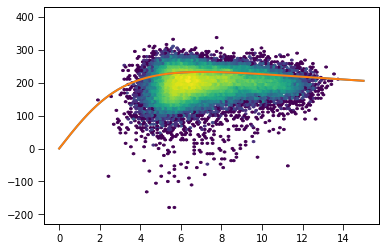

In [53]:
rotcur = lambda x, h, p : x/h * np.power(1+(x/h)**2, (p-2)/4)

rcyl = np.linspace(0,15,1000)
v0 = Vcirc_sun/rotcur(Rsun.value/1000, hbp, pbp)
print(v0)
print(hbp)
print(pbp)
# print(rotcur(rcyl, hbp, pbp))

def bp_function(r, p_param, h_param, v0):
    rotcur = lambda x : x/h_param * np.power(1 + (x/h_param)**2, (p_param-2)/4)
    vc = v0*rotcur(r)
    return v0 * r/h_param * np.power(1 + (r/h_param)**2, (p_param-2)/4)

# print(bp_function(rcyl, pbp, hbp, v0))

plt.plot(rcyl, v0*rotcur(rcyl, hbp, pbp), c='C0', lw=2)
plt.plot(rcyl, bp_function(rcyl, pbp, hbp, v0), c='C1')
plt.hexbin(fgkmtable['R_gc'][giants]/1000, fgkmtable['v_phi_gc'][giants], bins='log', mincnt=1, extent=[14, 1, -200, 400])

In [61]:
vsunpeculiar = np.array([Vsun_pec_x, Vsun_pec_y, Vsun_pec_z])

diskmodel_best = DiskKinematicModel(BrunettiPfennigerRotationCurve(Vcirc_sun, Rsun, hbp, pbp), sunpos, vsunpeculiar)


UnitConversionError: 'pc2' (area) and 'kpc' (length) are not convertible

(0.0, 360.0)

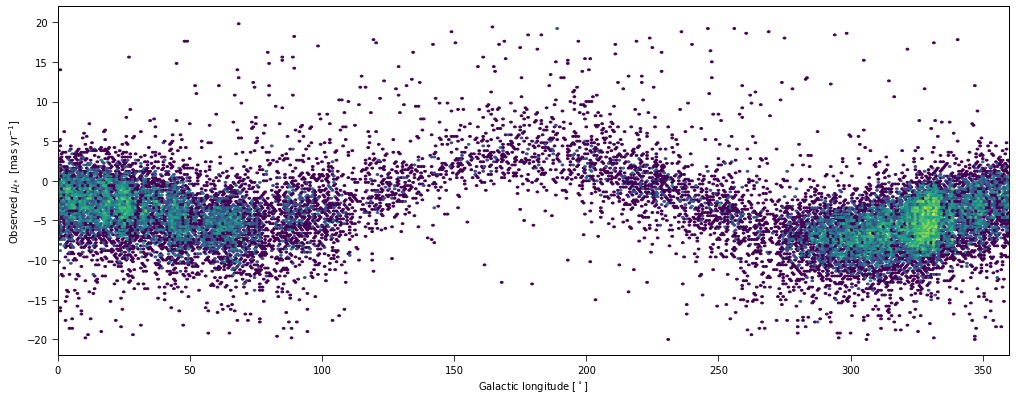

In [54]:
fig=plt.figure(constrained_layout=True, figsize=(14,4*5))

gs = GridSpec(4, 1, figure=fig)

ax_lmul = fig.add_subplot(gs[0,0])
im_lmul = ax_lmul.hexbin(fgkmtable['l'][sample_filter], fgkmtable['pml'][sample_filter], 
                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
ax_lmul.set_xlabel(r'Galactic longitude [$^\circ$]')
ax_lmul.set_ylabel(r'Observed $\mu_{\ell*}$ [mas yr$^{-1}$]')
ax_lmul.set_xlim(0,360)

pml_model = 